In [1]:
import pandas as pd
from prophet import Prophet

train_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\train_data.csv")
test_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\test_data.csv")

prophet_train = train_df[["date", "solar_radiation_langley"]].copy()
prophet_train.columns = ["ds", "y"]

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_train)

# For training data
train_future = prophet_train[["ds"]]
train_forecast = model.predict(train_future)

train_df["trend"] = train_forecast["trend"].values
train_df["seasonal"] = train_forecast["yearly"].values + train_forecast["daily"].values
train_df["residual"] = train_df["solar_radiation_langley"] - train_df["trend"] - train_df["seasonal"]

# For testing data
prophet_test = test_df[["date"]].copy()
prophet_test.columns = ["ds"]
test_forecast = model.predict(prophet_test)

test_df["trend"] = test_forecast["trend"].values
test_df["seasonal"] = test_forecast["yearly"].values + test_forecast["daily"].values
test_df["residual"] = test_df["solar_radiation_langley"] - test_df["trend"] - test_df["seasonal"]


input_features = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

X_train = train_df[input_features].values
y_train = train_df["solar_radiation_langley"].values

X_test = test_df[input_features].values
y_test = test_df["solar_radiation_langley"].values

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:27:45 - cmdstanpy - INFO - Chain [1] start processing
09:27:45 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = pd.DataFrame(X_train, columns=input_features).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\feature_correlation_heatmap.png")
plt.show()

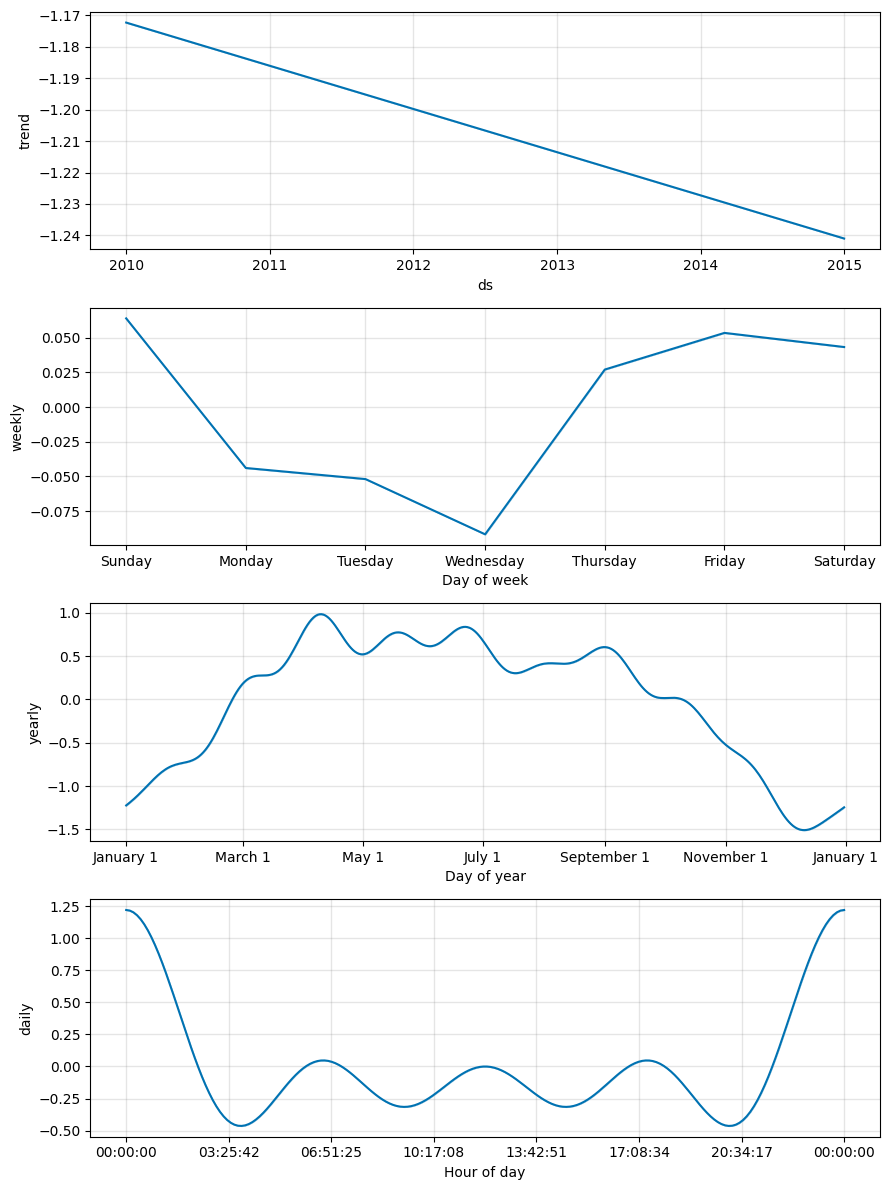

In [ ]:
model.plot_components(train_forecast)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\Prophet_components.png")
plt.show()

In [2]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---- Device Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"💻 Using device: {device}")

# ---- Hyperparameters ----
n_qubits = 4
n_layers = 2
theta_dim = 4
num_blocks = 2
epochs = 70
lr = 1e-3
batch_size = 8
forecast_dim = 1

# ---- Quantum device ----
dev = qml.device("lightning.qubit", wires=n_qubits)

# ---- Quantum circuit ----
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    for layer_weights in weights:
        for i in range(n_qubits):
            qml.RY(layer_weights[i], wires=i)
        for i in range(0, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# ---- QNode and TorchLayer ----
weight_shapes = {"weights": (n_layers, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="adjoint")
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# ==== Quantum N-HiTS Block ====
class QuantumNHITSBlock(nn.Module):
    def __init__(self, input_dim, theta_dim, forecast_dim):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, n_qubits)
        self.norm = nn.LayerNorm(n_qubits)
        self.q_layer = qlayer
        self.theta_fc = nn.Linear(n_qubits, theta_dim)
        self.backcast_fc = nn.Linear(theta_dim, input_dim)
        self.forecast_fc = nn.Linear(theta_dim, forecast_dim)

    def forward(self, x):
        x = self.norm(self.fc_in(x))
        x_q = self.q_layer(x)
        theta = self.theta_fc(x_q)
        backcast = self.backcast_fc(theta)
        forecast = self.forecast_fc(theta)
        return backcast, forecast

# ==== Quantum N-HiTS Model ====
class QuantumNHITS(nn.Module):
    def __init__(self, input_dim, theta_dim, forecast_dim, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            QuantumNHITSBlock(input_dim, theta_dim, forecast_dim)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        forecast_total = 0
        for block in self.blocks:
            backcast, forecast = block(x)
            forecast_total += forecast
            x = x - backcast
        return forecast_total

# ---- Convert to tensors ----
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# ---- DataLoaders ----
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# ---- Initialize model and training components ----
model = QuantumNHITS(input_dim=X_train.shape[1], theta_dim=theta_dim, forecast_dim=forecast_dim, num_blocks=num_blocks).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

💻 Using device: cuda


d:\Python\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
# ---- Training loop ----
train_losses = []
test_losses = []

best_val_loss = float('inf')
best_model_path = r"D:\Projects\quantum forecasting\models\best_quantum_model.pth"

print("Starting training...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_preds = model(test_x)
        test_loss = criterion(test_preds, test_y)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss.item())
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {test_loss.item():.4f}")

    # Save best model
    if test_loss.item() < best_val_loss:
        best_val_loss = test_loss.item()
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved new best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")

print("\nTraining complete.")

Starting training...

Epoch 1/70 - Train Loss: 0.3059 - Test Loss: 0.1762
✅ Saved new best model at epoch 1 with val loss 0.1762
Epoch 2/70 - Train Loss: 0.1031 - Test Loss: 0.0703
✅ Saved new best model at epoch 2 with val loss 0.0703
Epoch 3/70 - Train Loss: 0.0602 - Test Loss: 0.0516
✅ Saved new best model at epoch 3 with val loss 0.0516
Epoch 4/70 - Train Loss: 0.0434 - Test Loss: 0.0399
✅ Saved new best model at epoch 4 with val loss 0.0399
Epoch 5/70 - Train Loss: 0.0350 - Test Loss: 0.0338
✅ Saved new best model at epoch 5 with val loss 0.0338
Epoch 6/70 - Train Loss: 0.0293 - Test Loss: 0.0273
✅ Saved new best model at epoch 6 with val loss 0.0273
Epoch 7/70 - Train Loss: 0.0265 - Test Loss: 0.0255
✅ Saved new best model at epoch 7 with val loss 0.0255
Epoch 8/70 - Train Loss: 0.0247 - Test Loss: 0.0230
✅ Saved new best model at epoch 8 with val loss 0.0230
Epoch 9/70 - Train Loss: 0.0242 - Test Loss: 0.0221
✅ Saved new best model at epoch 9 with val loss 0.0221
Epoch 10/70 - T

In [3]:
model = QuantumNHITS(input_dim=X_test.shape[1], theta_dim=theta_dim, forecast_dim=forecast_dim, num_blocks=num_blocks)
best_model_path = r"D:\Projects\quantum forecasting\models\best_Qmodel_nhits1.pth"
model.load_state_dict(torch.load(best_model_path))
model.to(device)  # 🟢 This is the fix — move model to GPU

# Also make sure input data is on GPU
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

with torch.no_grad():
    y_pred = model(X_test_t)
    test_loss = criterion(y_pred, y_test_t)
    print(f"✅ Loaded best model - Test Loss: {test_loss.item():.4f}")


C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_15896\1658786898.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


✅ Loaded best model - Test Loss: 0.0133


In [10]:
from torchinfo import summary

# Assuming batch size 32
summary(model, input_size=(16, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
QuantumNHITS                             [16, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─QuantumNHITSBlock: 2-1            [16, 9]                   78
│    │    └─Linear: 3-1                  [16, 4]                   40
│    │    └─LayerNorm: 3-2               [16, 4]                   8
│    └─QuantumNHITSBlock: 2-2            --                        (recursive)
│    │    └─TorchLayer: 3-3              [16, 4]                   8
│    └─QuantumNHITSBlock: 2-3            --                        (recursive)
│    │    └─Linear: 3-4                  [16, 4]                   20
│    │    └─Linear: 3-5                  [16, 9]                   45
│    │    └─Linear: 3-6                  [16, 1]                   5
│    └─QuantumNHITSBlock: 2-4            [16, 9]                   8
│    │    └─Linear: 3-7                  [16, 4]                   40
│

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure predictions and targets are NumPy arrays
y_pred_np = y_pred.cpu().numpy().flatten()
y_test_np = y_test_t.cpu().numpy().flatten()

# Compute accuracy metrics
mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.1234
Mean Squared Error (MSE): 0.0266
Root Mean Squared Error (RMSE): 0.1632
R² Score: 0.9727


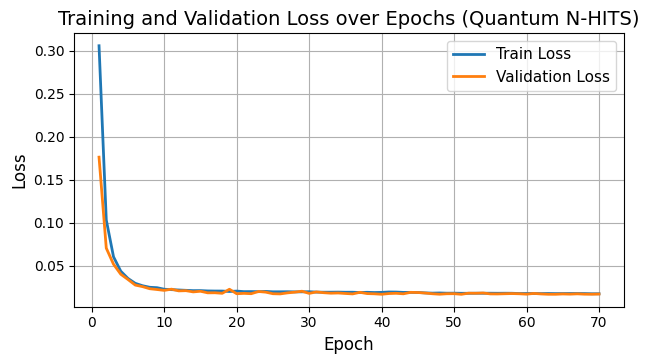

In [13]:
import matplotlib.pyplot as plt

# Apply journal style formatting
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6.5, 3.8))  # IEEE 1-column size

plt.plot(epochs, train_losses, label='Train Loss', linewidth=2)
plt.plot(epochs, test_losses, label='Validation Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (Quantum N-HITS)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save high-resolution version
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNHITS\loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()


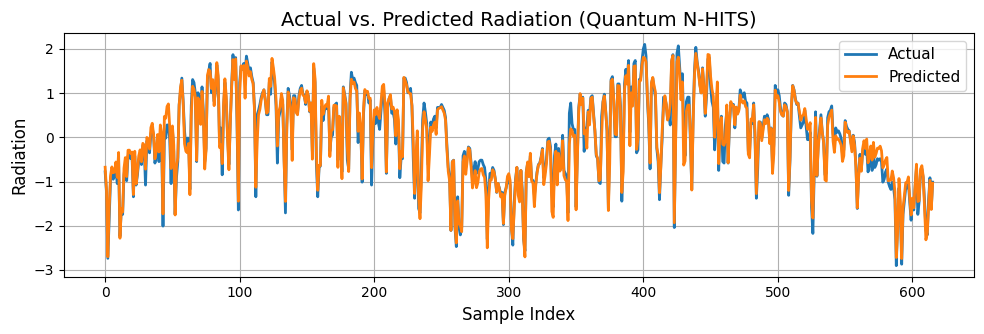

In [5]:
import matplotlib.pyplot as plt

# Set global font styles for publication quality
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

# Create plot
plt.figure(figsize=(10, 3.5))  # Ideal for one-column width (approx 3.5–3.7 in in journals)
plt.plot(y_test_np, label='Actual', linewidth=2)
plt.plot(y_pred_np, label='Predicted', linewidth=2)

plt.title("Actual vs. Predicted Radiation (Quantum N-HITS)")
plt.xlabel("Sample Index")
plt.ylabel("Radiation")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNHITS\actual_vs_predicted.png", dpi=300, bbox_inches='tight')

plt.show()


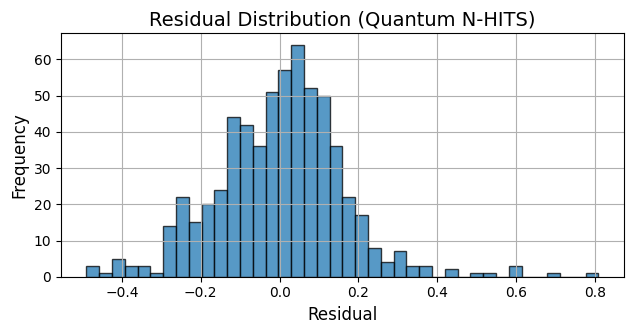

In [18]:
import matplotlib.pyplot as plt

# Set publication-style font configuration
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

residuals = y_test_np - y_pred_np

# Plot residual histogram
plt.figure(figsize=(6.5, 3.5))  # Suitable for 1-column figure (IEEE ~3.5 in width)
plt.hist(residuals, bins=40, alpha=0.75, edgecolor='black')

plt.title("Residual Distribution (Quantum N-HITS)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

# Save high-resolution image
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNHITS\residual_distribution.png", dpi=300, bbox_inches='tight')

plt.show()


d:\Python\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


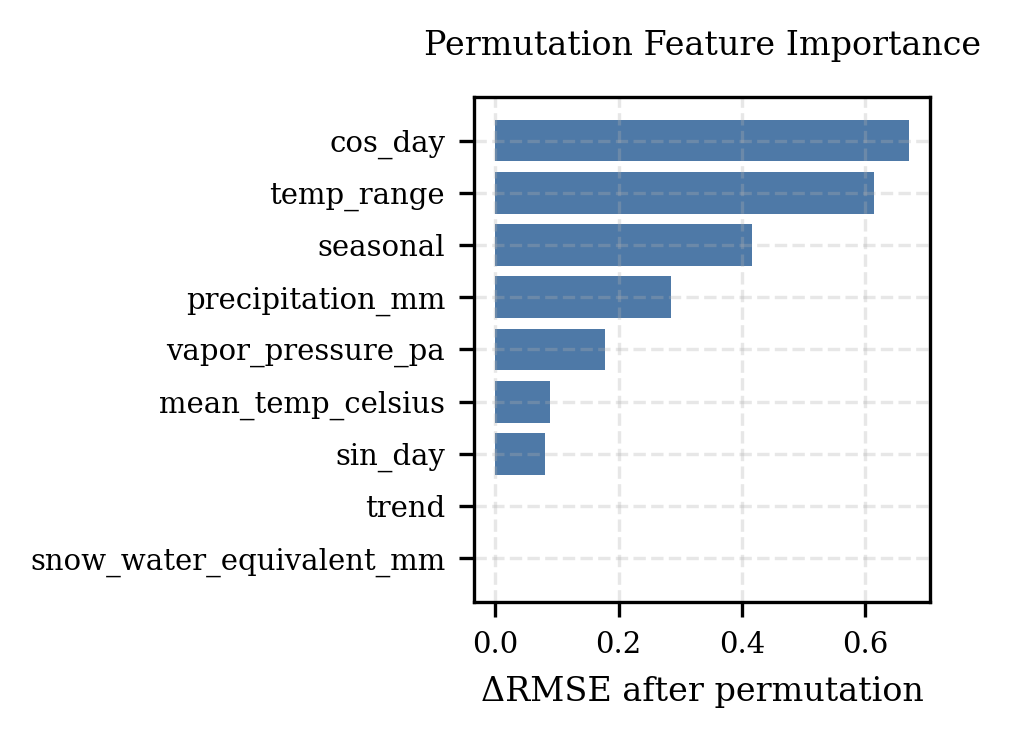

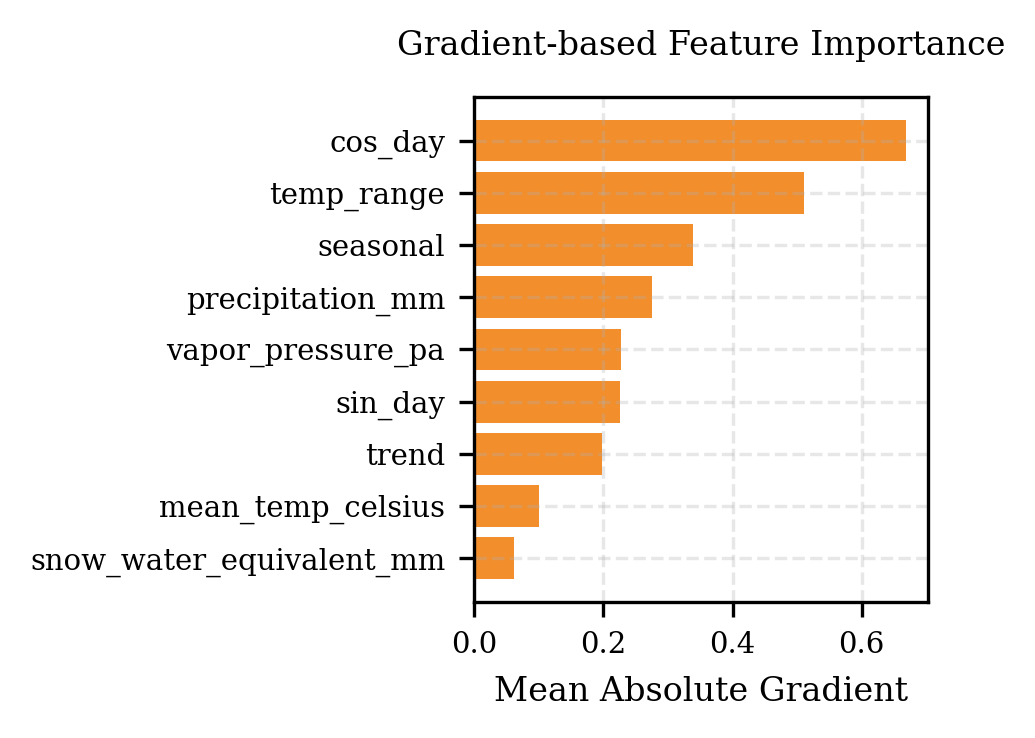

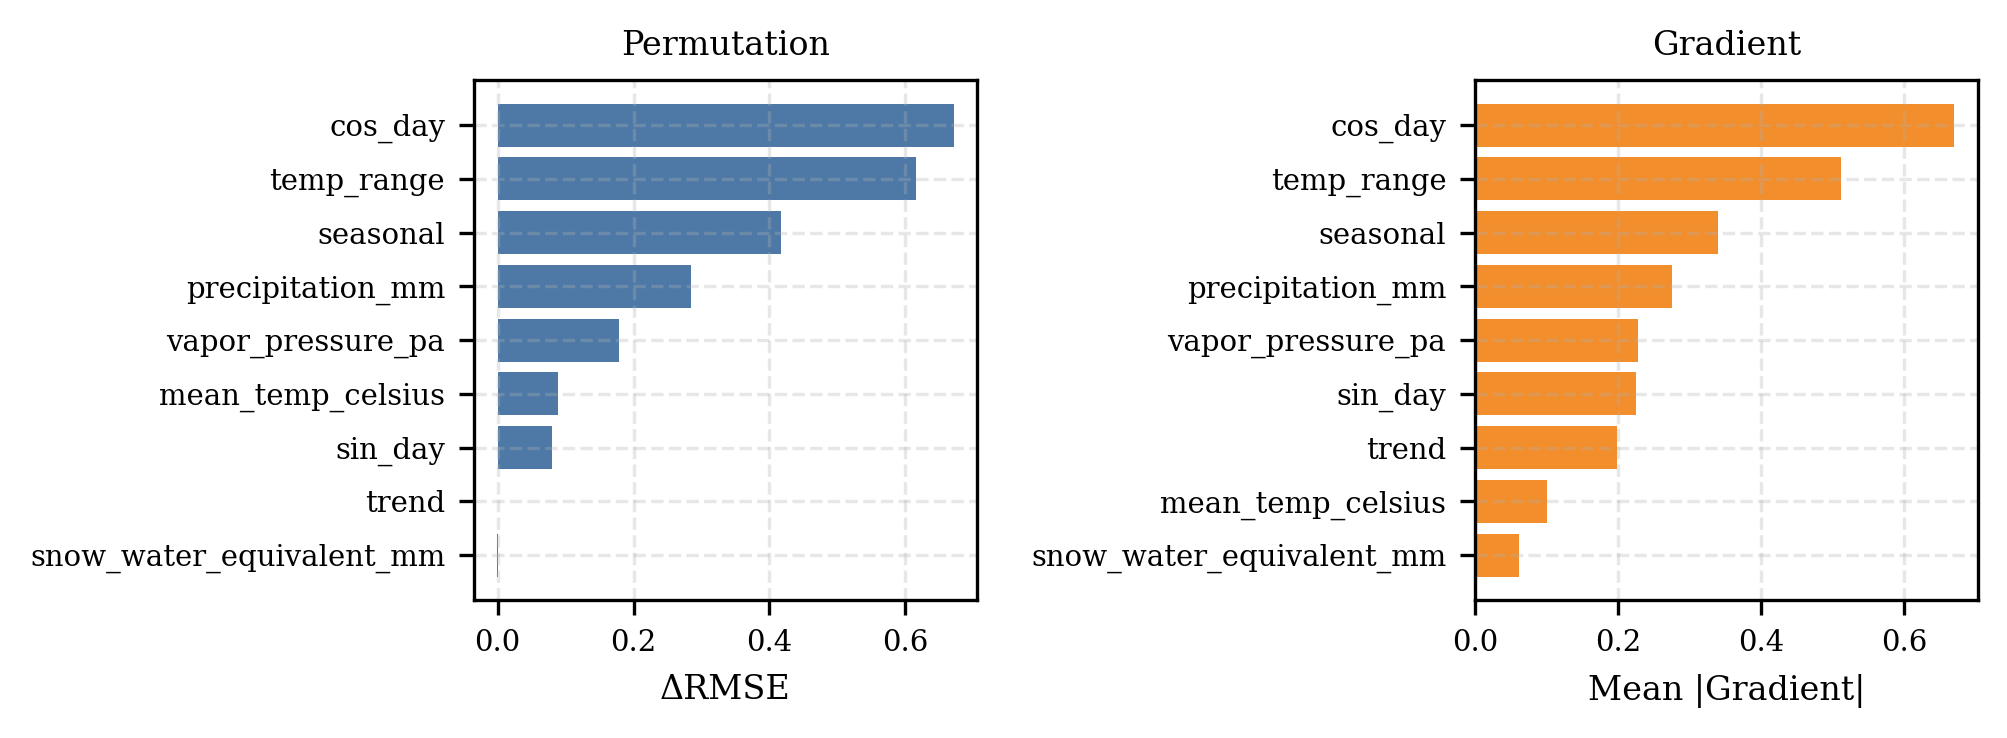

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from sklearn.metrics import mean_squared_error

# ---------- PREPARE ----------
model.eval()

# Ensure all tensors are on the same device as the model
device = next(model.parameters()).device
X_test_perm = X_test_t.clone().to(device)
y_test_true = y_test_t.clone().to(device)
base_preds = model(X_test_perm).detach().cpu().numpy().flatten()
base_rmse = np.sqrt(mean_squared_error(y_test_true.cpu().numpy().flatten(), base_preds))

# ---------- PERMUTATION IMPORTANCE ----------
perm_importances = []
feature_names = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

for i in range(X_test_perm.shape[1]):
    X_permuted = X_test_perm.clone()
    idx = torch.randperm(X_test_perm.size(0))
    X_permuted[:, i] = X_permuted[idx, i]  # Shuffle one column
    perm_preds = model(X_permuted).detach().cpu().numpy().flatten()
    perm_rmse = np.sqrt(mean_squared_error(y_test_true.cpu().numpy(), perm_preds))
    importance = perm_rmse - base_rmse
    perm_importances.append(importance)

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (RMSE Increase)": perm_importances
}).sort_values(by="Importance (RMSE Increase)", ascending=True)

# ---------- GRADIENT-BASED IMPORTANCE ----------
X_test_t = X_test_t.to(device)
X_test_t.requires_grad = True
grad_importances = torch.zeros(X_test_t.shape[1], device=device)


for i in range(X_test_t.shape[0]):
    model.zero_grad()
    output = model(X_test_t[i:i+1])
    output.backward(torch.ones_like(output))
    grad_importances += X_test_t.grad[i].abs().detach()

grad_importances /= X_test_t.shape[0]
grad_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Gradient Importance": grad_importances.cpu().numpy()
}).sort_values(by="Gradient Importance", ascending=True)

# ---------- IEEE/Elsevier PLOTTING ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.figsize": (3.3, 2.5),
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})

# --- Permutation Plot ---
plt.figure()
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
plt.xlabel("ΔRMSE after permutation")
plt.title("Permutation Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNHITS\permutation_importance.png")
plt.show()

# --- Gradient Plot ---
plt.figure()
plt.barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
plt.xlabel("Mean Absolute Gradient")
plt.title("Gradient-based Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNHITS\gradient_importance.png")
plt.show()

# --- Combined Plot (Optional) ---
fig, ax = plt.subplots(1, 2, figsize=(6.8, 2.5))
ax[0].barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
ax[0].set_title("Permutation", fontsize=8)
ax[0].set_xlabel("ΔRMSE", fontsize=8)

ax[1].barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
ax[1].set_title("Gradient", fontsize=8)
ax[1].set_xlabel("Mean |Gradient|", fontsize=8)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=7)
    a.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNHITS\feature_importance_combined.png")
plt.show()
